In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance


In [2]:
# Data Cleaning
df = pd.read_csv("library_occupancy_data.csv")
df = df.dropna().reset_index(drop=True)

# Parse day of week to numeric
day_map = {'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,
           'Friday':5,'Saturday':6}
df['DayOfWeek_num'] = df['DayOfWeek'].map(day_map)

# Parse time and derive hour
t = pd.to_datetime(df['Time'], format='%I:%M %p', errors='coerce')
df['Hour'] = t.dt.hour + t.dt.minute/60


In [3]:
# Hours helper
def in_range(h, start, end):
    """Return True if hour h is within [start, end) in 24h format."""
    return (h >= start) and (h < end)

# IsClosed per library
def is_closed_olin(row):
    h, d = row['Hour'], row['DayOfWeek']
    if d in ['Monday','Tuesday','Wednesday','Thursday']: return 0 if in_range(h, 8, 24) else 1
    if d == 'Friday': return 0 if in_range(h, 8, 18) else 1
    if d == 'Saturday': return 0 if in_range(h, 10, 18) else 1
    if d == 'Sunday': return 0 if in_range(h, 10, 24) else 1
    return 1

def is_closed_uris(row):
    h, d = row['Hour'], row['DayOfWeek']
    if d in ['Monday','Tuesday','Wednesday','Thursday']: return 0 if in_range(h, 8, 23) else 1
    if d == 'Friday': return 0 if in_range(h, 8, 17) else 1
    if d == 'Saturday': return 0 if in_range(h, 12, 17) else 1
    if d == 'Sunday': return 0 if in_range(h, 12, 23) else 1
    return 1

def is_closed_mann(row):
    h, d = row['Hour'], row['DayOfWeek']
    if d in ['Monday','Tuesday','Wednesday','Thursday']: return 0 if in_range(h, 8, 22) else 1
    if d == 'Friday': return 0 if in_range(h, 8, 18) else 1
    if d == 'Saturday': return 0 if in_range(h, 12, 18) else 1
    if d == 'Sunday': return 0 if in_range(h, 12, 22) else 1
    return 1

def is_closed_math(row):
    h, d = row['Hour'], row['DayOfWeek']
    if d in ['Saturday', 'Sunday']:
        return 1
    return 0 if in_range(h, 9, 16) else 1

df['IsClosed_Olin'] = df.apply(is_closed_olin, axis=1)
df['IsClosed_Uris'] = df.apply(is_closed_uris, axis=1)
df['IsClosed_Mann'] = df.apply(is_closed_mann, axis=1)
df['IsClosed_Math'] = df.apply(is_closed_math, axis=1)

# Drop rows if anything essential failed to parse
req = ['Hour','DayOfWeek_num','IsClosed_Olin','IsClosed_Uris',
       'IsClosed_Mann','IsClosed_Math']
df = df.dropna(subset=req).reset_index(drop=True)



In [4]:
# Cross-Validated Modeling (with IsClosed_*)
libraries = ['Mann','Olin','Uris','Math']
cv = KFold(n_splits=5, shuffle=True, random_state=42)

results_with = []

for lib in libraries:
    X_lib = df[['Hour', 'DayOfWeek_num', f'IsClosed_{lib}']]
    y_lib = df[lib]

    lr = LinearRegression()
    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    lr_scores = cross_val_score(lr, X_lib, y_lib, scoring='r2', cv=cv)
    rf_scores = cross_val_score(rf, X_lib, y_lib, scoring='r2', cv=cv)

    results_with.append({
        'Library': lib,
        'Linear R² (with IsClosed)': lr_scores.mean(),
        'RF R² (with IsClosed)': rf_scores.mean()
    })

results_with_df = pd.DataFrame(results_with).round(3)
results_with_df

,Library,Linear R² (with IsClosed),RF R² (with IsClosed)
0,Mann,0.230,0.261
1,Olin,0.262,0.310
2,Uris,-0.074,-0.016
3,Math,0.114,0.676


,Library,Linear R² (with IsClosed),RF R² (with IsClosed),Linear R² (baseline),RF R² (baseline)
0,Mann,0.230,0.261,0.080,0.244
1,Olin,0.262,0.310,0.059,0.297
2,Uris,-0.074,-0.016,-0.134,-0.037
3,Math,0.114,0.676,0.064,0.642


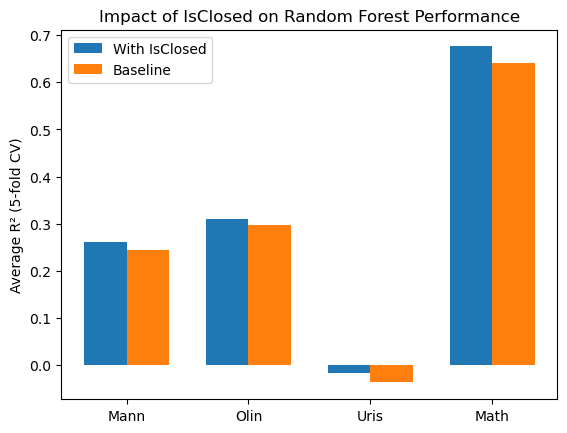

In [ ]:
# Baseline model 

results_base = []
for lib in libraries:
    X_base = df[['Hour', 'DayOfWeek_num']]
    y_lib  = df[lib]

    lr = LinearRegression()
    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    lr_scores = cross_val_score(lr, X_base, y_lib, scoring='r2', cv=cv)
    rf_scores = cross_val_score(rf, X_base, y_lib, scoring='r2', cv=cv)

    results_base.append({
        'Library': lib,
        'Linear R² (baseline)': lr_scores.mean(),
        'RF R² (baseline)': rf_scores.mean()
    })

results_base_df = pd.DataFrame(results_base).round(3)

# Merge & visualize RF
compare_df = results_with_df.merge(results_base_df, on='Library')
display(compare_df)

# Bar chart for RF only
plt.figure()
w = 0.35
x = np.arange(len(compare_df))
plt.bar(x - w/2, compare_df['RF R² (with IsClosed)'], width=w, label='With IsClosed')
plt.bar(x + w/2, compare_df['RF R² (baseline)'], width=w, label='Baseline')
plt.xticks(x, compare_df['Library'])
plt.ylabel('Average R² (5-fold CV)')
plt.title('Impact of IsClosed on Random Forest Performance')
plt.legend()
plt.show()

# Adding IsClosed shows slight improvement in the model's performance



In [6]:
# MAE via Cross Validation (Random Forest)

mae_rows = []
for lib in libraries:
    X_lib = df[['Hour', 'DayOfWeek_num', f'IsClosed_{lib}']]
    y_lib = df[lib]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    maes = []
    for train_idx, test_idx in cv.split(X_lib):
        rf.fit(X_lib.iloc[train_idx], y_lib.iloc[train_idx])
        preds = rf.predict(X_lib.iloc[test_idx])
        maes.append(mean_absolute_error(y_lib.iloc[test_idx], preds))

    mae_rows.append({'Library': lib, 'RF MAE (with IsClosed)': np.mean(maes)})

mae_df = pd.DataFrame(mae_rows).round(2)
mae_df

,Library,RF MAE (with IsClosed)
0,Mann,69.55
1,Olin,128.34
2,Uris,84.95
3,Math,32.02


The cell below is code for Date-CV which makes RF struggle, but improves the model - we could use it to retest our model after we've added additional features like "Prelim Week.
Date-CV shows that the model right now is good for predictions within the same day but struggles with unseen days predictions. 

In [7]:
# df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y', errors='coerce')
# gcv = GroupKFold(n_splits=5)
#groups = df['Date']  
#def cv_r2_table(group_cv):
   # rows = []
   # for lib in libraries:
    #    X = df[['Hour','DayOfWeek_num', f'IsClosed_{lib}']]
      #  y = df[lib]
      #  lr = LinearRegression()
      #  rf = RandomForestRegressor(n_estimators=100, random_state=42)

       # lr_scores = cross_val_score(lr, X, y, scoring='r2', cv=group_cv, groups=groups)
       # rf_scores = cross_val_score(rf, X, y, scoring='r2', cv=group_cv, groups=groups)

      #  rows.append({'Library': lib,
      #               'Linear R² (Date-CV)': lr_scores.mean(),
       #              'RF R² (Date-CV)': rf_scores.mean()})
    #return pd.DataFrame(rows).round(3)

#results_datecv_df = cv_r2_table(gcv)
#display(results_datecv_df)  
# remember to import GroupKFold

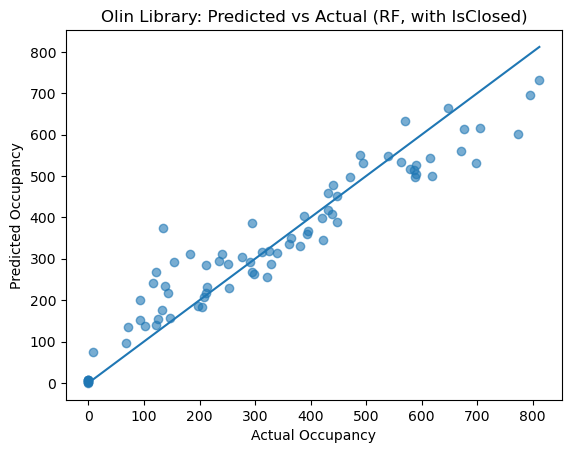

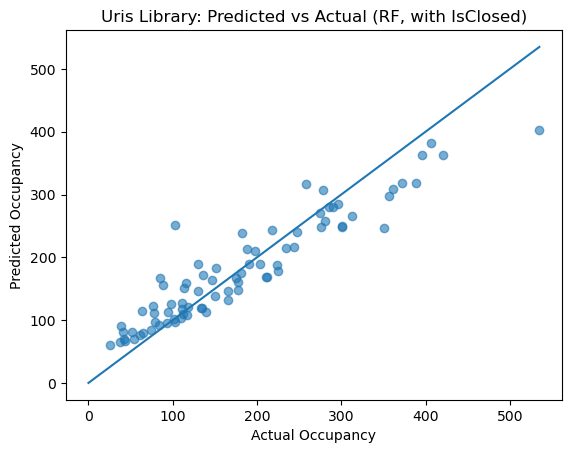

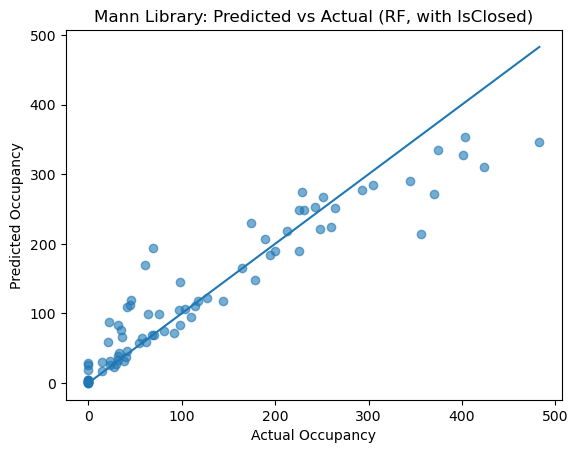

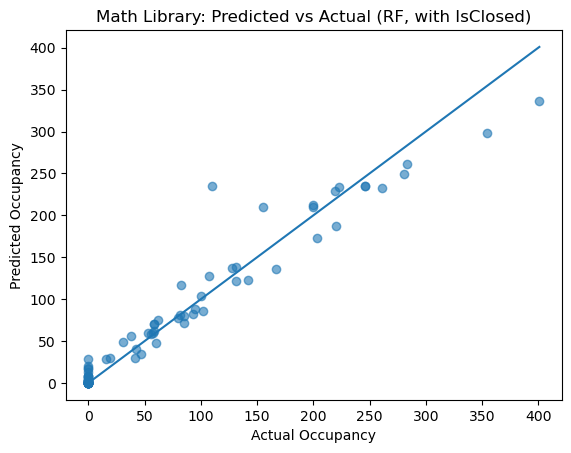

In [8]:
# Predicted vs Actual

for lib in ['Olin','Uris','Mann','Math']:
    X_lib = df[['Hour', 'DayOfWeek_num', f'IsClosed_{lib}']]
    y_lib = df[lib]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_lib, y_lib)
    preds = rf.predict(X_lib)

    plt.figure()
    plt.scatter(y_lib, preds, alpha=0.6)
    plt.xlabel("Actual Occupancy")
    plt.ylabel("Predicted Occupancy")

    # Add reference (45°) line
    lim = max(y_lib.max(), preds.max())
    plt.plot([0, lim], [0, lim])

    plt.title(f"{lib} Library: Predicted vs Actual (RF, with IsClosed)")
    plt.show()



In [9]:
# Feature Importance

for lib in ['Olin', 'Uris', 'Mann', 'Math']:
    X_lib = df[['Hour', 'DayOfWeek_num', f'IsClosed_{lib}']]
    y_lib = df[lib]

    rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_lib, y_lib)
    imp = pd.Series(rf.feature_importances_, index=X_lib.columns).sort_values(ascending=False)
    print(f"\n{lib} feature importance:")
    display(imp.round(3))



Olin feature importance:


Hour             0.606
DayOfWeek_num    0.289
IsClosed_Olin    0.105
dtype: float64


Uris feature importance:


Hour             0.802
DayOfWeek_num    0.165
IsClosed_Uris    0.033
dtype: float64


Mann feature importance:


Hour             0.761
IsClosed_Mann    0.122
DayOfWeek_num    0.117
dtype: float64


Math feature importance:


Hour             0.734
DayOfWeek_num    0.207
IsClosed_Math    0.059
dtype: float64

In [10]:
# Summary
final_table = compare_df.merge(mae_df, on='Library')
final_table = final_table[['Library',
                           'Linear R² (baseline)','RF R² (baseline)',
                           'Linear R² (with IsClosed)','RF R² (with IsClosed)',
                           'RF MAE (with IsClosed)']].round(3)
display(final_table)


,Library,Linear R² (baseline),RF R² (baseline),Linear R² (with IsClosed),RF R² (with IsClosed),RF MAE (with IsClosed)
0,Mann,0.080,0.244,0.230,0.261,69.55
1,Olin,0.059,0.297,0.262,0.310,128.34
2,Uris,-0.134,-0.037,-0.074,-0.016,84.95
3,Math,0.064,0.642,0.114,0.676,32.02
